In [1]:
%load_ext autoreload
%autoreload 2

Load dataset

In [2]:
import os
from internal.dataparsers.colmap_dataparser import Colmap

In [3]:
dataset_path = os.path.expanduser("~/dataset/dbl/parsed_from_exif-sift_matching/dense_1600-from_hie_map")
partition_path = os.path.join(dataset_path, "partitions-size_5.0-enlarge_0.1-visibility_0.9_0.1")
partition_id_str = "000_003"

In [4]:
dataparser_outputs = Colmap(
    image_list=os.path.join(partition_path, "{}.txt".format(partition_id_str)),
    eval_image_select_mode="list-optional",
    eval_list=os.path.join(dataset_path, "test_set.txt"),
    split_mode="experiment",
).instantiate(dataset_path, 0, 0).get_outputs()
# dataparser_outputs

appearance group by camera id
loading colmap 3D points
[WARNING]Some images can not be found in colmap sparse model: ['h/22h00395.JPG', 'h/22h00455.JPG', 'h/22h00515.JPG', 'h/22h00576.JPG', 'h/22h00636.JPG', 'h/22h00696.JPG', 'h/22h00756.JPG', 'h/22h00816.JPG', 'h/22h00876.JPG', 'h/22h00949.JPG', 'h/22h01009.JPG', 'h/22h01069.JPG', 'h/22h01189.JPG', 'h/22h01259.JPG', 'h/22h01319.JPG', 'h/22h01380.JPG', 'h/22h01450.JPG', 'h/22h01510.JPG', 'h/22h01574.JPG', 'h/22h01634.JPG', 'h/22h01694.JPG', 'h/22h01754.JPG', 'h/23h00116.JPG', 'h/23h00176.JPG', 'h/23h00236.JPG', 'h/24h00024.JPG', 'h/24h00084.JPG', 'h/24h00144.JPG', 'q/22q00342.JPG', 'q/22q00402.JPG', 'q/22q00462.JPG', 'q/22q00522.JPG', 'q/22q00582.JPG', 'q/22q00642.JPG', 'q/22q00703.JPG', 'q/22q00763.JPG', 'q/22q00824.JPG', 'q/22q00887.JPG', 'q/22q00953.JPG', 'q/22q01013.JPG', 'q/22q01075.JPG', 'q/22q01135.JPG', 'q/22q01196.JPG', 'q/22q01265.JPG', 'q/22q01325.JPG', 'q/22q01394.JPG', 'q/22q01514.JPG', 'q/22q01576.JPG', 'q/22q01696.JPG', 

Load partition data

In [5]:
import torch
from internal.utils.partitioning_utils import PartitionCoordinates
partition_data = torch.load(os.path.join(partition_path, "partitions.pt"))
partition_coordinates = PartitionCoordinates(**partition_data["partition_coordinates"])

In [6]:
partition_idx = -1
for idx, _ in enumerate(partition_coordinates):
    if partition_coordinates.get_str_id(idx) == partition_id_str:
        partition_idx = idx
        break
assert partition_idx >= 0
partition_idx

46

In [7]:
partition_data["scene_config"]["partition_size"]

5.0

In [8]:
# partition center
partition_box = partition_coordinates.get_bounding_boxes(partition_data["scene_config"]["partition_size"])[partition_idx]
partition_center = (partition_box.min + partition_box.max) * 0.5
partition_center

tensor([ 0., 19.])

Create model and density controller

In [9]:
from internal.models.vanilla_gaussian import VanillaGaussian
gaussian_model = VanillaGaussian(
    sh_degree=0,
).instantiate()
gaussian_model.setup_from_pcd(xyz=dataparser_outputs.point_cloud.xyz, rgb=dataparser_outputs.point_cloud.rgb)

In [10]:
from internal.density_controllers.foreground_first_density_controller import ForegroundFirstDensityController
density_controller = ForegroundFirstDensityController(
    partition=partition_path,
    partition_idx=partition_idx,
).instantiate()
density_controller.setup(stage="validate", pl_module=None)

partition_idx=#46, id=tensor([0, 3], dtype=torch.int32), transform=[[0.9906935691833496, -0.1124858558177948, 0.07663705945014954, 0.0], [-0.1015680804848671, -0.9857741594314575, -0.13391463458538055, 0.0], [0.0906103253364563, 0.1248844787478447, -0.9880251288414001, 0.0], [0.0, 0.0, 0.0, 1.0]], center=[0.0, 19.0], radius=3.535533905029297


In [11]:
density_controller.rotation_transform

tensor([[ 0.9907, -0.1125,  0.0766,  0.0000],
        [-0.1016, -0.9858, -0.1339,  0.0000],
        [ 0.0906,  0.1249, -0.9880,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

Get mask

In [12]:
def get_partition_gaussian_mask(
        means: torch.Tensor,
        partition_bounding_box,
        orientation_transform: torch.Tensor = None,
):
    if orientation_transform is not None:
        means = means @ orientation_transform[:3, :3].T

    # include min bound, exclude max bound
    is_ge_min = torch.prod(torch.ge(means[..., :2], partition_bounding_box.min), dim=-1)
    is_lt_max = torch.prod(torch.lt(means[..., :2], partition_bounding_box.max), dim=-1)
    is_in_bounding_box = torch.logical_and(is_ge_min, is_lt_max)

    return is_in_bounding_box, means

In [13]:
is_inside_partition, transformed_means = get_partition_gaussian_mask(
    gaussian_model.get_means(),
    partition_bounding_box=partition_box,
    orientation_transform=partition_data["extra_data"]["rotation_transform"],
)

Get grad factors

In [14]:
grad_factors = density_controller._get_grad_decay_factors(gaussian_model)

In [15]:
assert torch.allclose(density_controller.partition_center, partition_center), (density_controller.partition_center, partition_center)

In [16]:
assert torch.allclose(grad_factors[is_inside_partition], torch.tensor(1.))

In [17]:
partition_radius = density_controller.partition_radius
partition_radius

tensor(3.5355)

In [18]:
distances = torch.norm(transformed_means[:, :2] - partition_center, dim=-1)

In [19]:
for idx in [0, 16, 32]:
    print("#{}, distance={}, distance_radius_factor={}, grad_factor={}".format(
        idx,
        distances[idx],
        distances[idx] / partition_radius,
        grad_factors[idx],
    ))

#0, distance=5.698302268981934, distance_radius_factor=1.6117233037948608, grad_factor=2.0
#16, distance=4.107719421386719, distance_radius_factor=1.1618385314941406, grad_factor=1.3236770629882812
#32, distance=3.1625254154205322, distance_radius_factor=0.894497275352478, grad_factor=1.0


In [20]:
partition_box

MinMaxBoundingBox(min=tensor([-2.5000, 16.5000]), max=tensor([ 2.5000, 21.5000]))

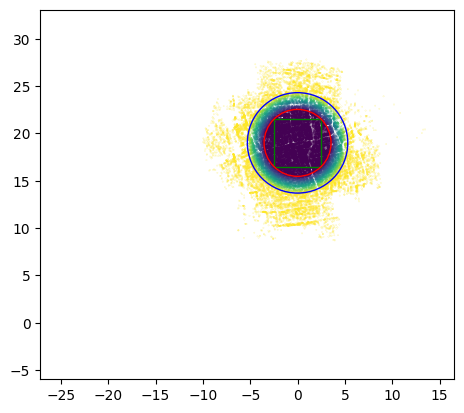

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

with torch.no_grad():
    fig, ax = plt.subplots()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim([
        transformed_means[:, 0].min(),
        transformed_means[:, 0].max(),
    ])
    ax.set_ylim([
        transformed_means[:, 1].min(),
        transformed_means[:, 1].max(),
    ])
    ax.scatter(
        x=transformed_means[::16, 0],
        y=transformed_means[::16, 1],
        s=0.01,
        c=grad_factors[::16] - 1.
    )
    # all of the rectangles and circles share a common center
    ax.add_artist(mpatches.Rectangle(
        partition_box.min.tolist(),
        partition_box.max[0] - partition_box.min[0],
        partition_box.max[1] - partition_box.min[1],
        fill=False,
        color="green",
    ))
    # grad_factor=1 inside this circle
    ax.add_artist(mpatches.Circle(
        xy=partition_center.tolist(),
        radius=partition_radius,
        fill=False,
        color="red",
    ))
    # grad_factor=2 outside this
    ax.add_artist(mpatches.Circle(
        xy=partition_center.tolist(),
        radius=partition_radius * density_controller.config.max_radius_factor,
        fill=False,
        color="blue",
    ))
    plt.show()